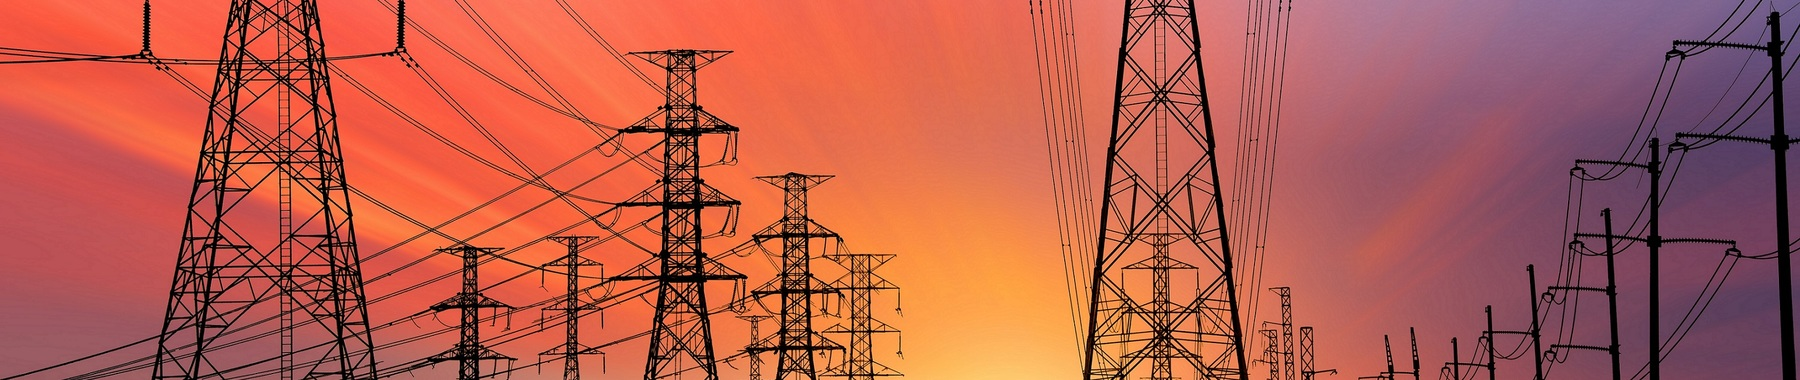

Importing dependencies

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

import xgboost as Xgb

In [5]:
import warnings
warnings.filterwarnings('ignore')

Loading te dataset

In [6]:
df = pd.read_csv('/content/PJME_hourly.csv')

In [7]:
#print 5 rows
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [8]:
# printing info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [9]:
# setting datetime as the index of our dataframe
df = df.set_index('Datetime')
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [10]:
# convert date to datetime
df.index = pd.to_datetime(df.index)

EDA

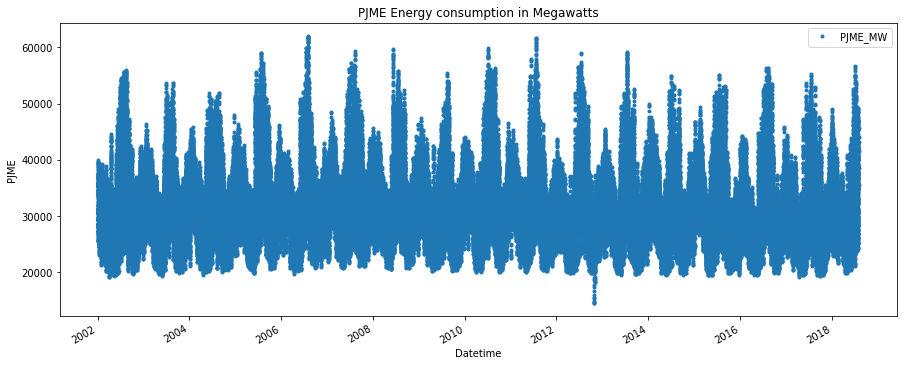

In [11]:
# Visualizing our dataset
palette = sns.color_palette()

df.plot(style='.', figsize=(15,6), 
        color=palette[0], 
        title = 'PJME Energy consumption in Megawatts',
        ylabel= ('PJME'))
plt.show()

>From the above depiction it seams there two different peaks which is common in energy consumption which also varies during the night when people retire to beds, also its possible that there is effect on holidays and weekends and maybe blackout like the case of 2013 PJME seem very low from the rest

Splitting our data

In [12]:
""" splitting train data to all data prior 2015
    and test data to after 2015
"""
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

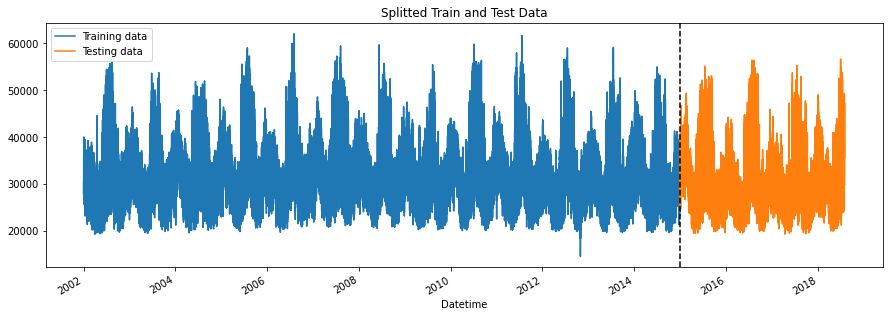

In [13]:
# Visualizing our test and train data
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training data', title='Splitted Train and Test Data')
test.plot(ax=ax, label='Testing data')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training data','Testing data'])
plt.show()

>From the above depiction it seams there two different peaks which is common in energy consumption which also varies during the night when people retire to beds, also its possible that there is effect on holidays and weekends and maybe blackout like the case of 2013 PJME seem very low from the rest.
There is uniformatity of trend in both test and train data

Feature Creation using dataframe index

In [14]:
""" This function takes df.index and split it to 
    hour,day,year and quarter of year and append them as columns
"""
def create_feartures(df):
  df = df.copy()
  df['Hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['month'] = df.index.month
  df['quarter'] = df.index.quarter
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear

  return df

#applying the function
df = create_feartures(df)



Features Visualization to Target Variable

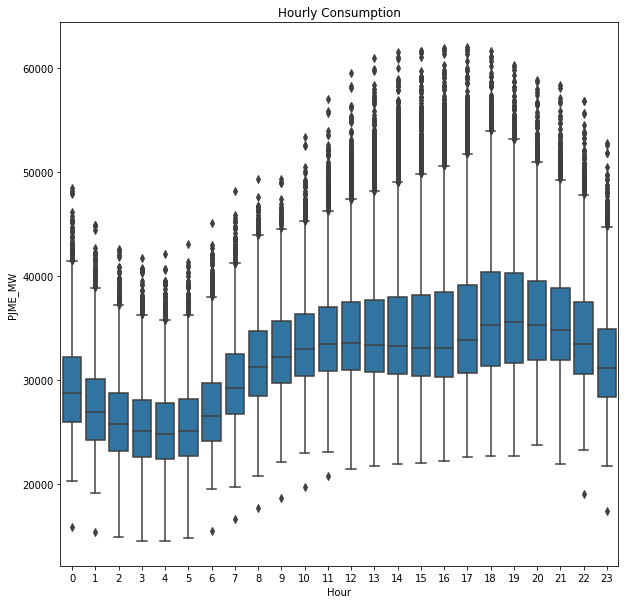

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=df, x = 'Hour', y = 'PJME_MW',color=palette[0] )
ax.set_title('Hourly Consumption');

>It observed that early in the morning power consumtion is a bit low but high during the day which is relatable and slowly trends down during the night up to 2300hrs which i assume peple are retiring to bed. There are outliers

Model Creation

In [16]:
train = create_feartures(train)
test = create_feartures(test)

features = ['Hour', 'dayofweek', 'month', 'quarter', 'year','dayofyear']
target = ['PJME_MW']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [17]:
reg = Xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=100)

[13:22:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.1	validation_1-rmse:31657.2
[100]	validation_0-rmse:12581.2	validation_1-rmse:11743.8
[200]	validation_0-rmse:5835.12	validation_1-rmse:5365.68
[300]	validation_0-rmse:3915.76	validation_1-rmse:4020.67
[400]	validation_0-rmse:3443.17	validation_1-rmse:3853.4
[500]	validation_0-rmse:3285.34	validation_1-rmse:3805.3
[600]	validation_0-rmse:3201.93	validation_1-rmse:3772.45
[700]	validation_0-rmse:3148.14	validation_1-rmse:3750.91
[800]	validation_0-rmse:3109.24	validation_1-rmse:3733.9
[900]	validation_0-rmse:3079.4	validation_1-rmse:3725.61
[999]	validation_0-rmse:3052.74	validation_1-rmse:3722.92


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

Feature Importance

In [18]:
from xgboost import XGBRegressor

In [19]:
reg.get_booster().get_score(importance_type='gain')

{'Hour': 48801329742.15155,
 'dayofyear': 19933179640.0,
 'dayofweek': 26493372461.92053,
 'year': 3982559015.198711,
 'month': 41867912933.39884}

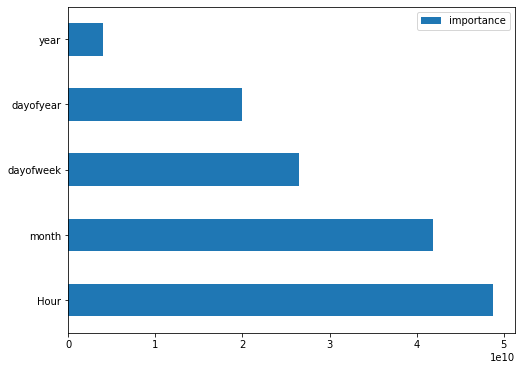

In [20]:
feature_important = reg.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["importance"]).sort_values(by = "importance", ascending=True)
data.nlargest(7, columns="importance").plot(kind='barh', figsize = (8,6));

Forecasting on Test data

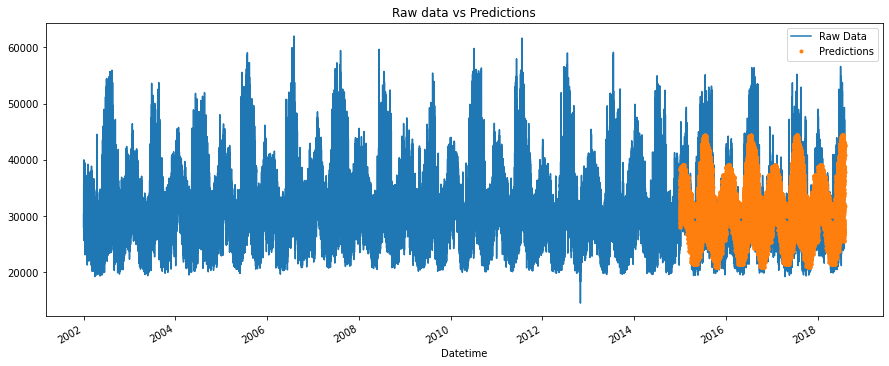

In [21]:
test['prediction'] = reg.predict(X_test)

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15,6))
df['prediction'].plot(ax=ax, style ='.')
plt.legend(['Raw Data', 'Predictions'])
ax.set_title('Raw data vs Predictions')
plt.show()

From The above prediction my model need some improvement since is quite off on prediction

## Improving the model through:
* Outlier Analysis
* Forecasting horizon
* Time series cross validation
* lag feartures



In [22]:
df1 = pd.read_csv('/content/PJME_hourly.csv')
df1 = df1.set_index('Datetime')
df1.index = pd.to_datetime(df1.index)

Outlier Analysis

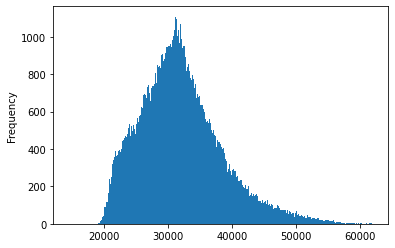

In [23]:
df['PJME_MW'].plot(kind='hist', bins=500);

From the above visual, consumption seem to be between 20k, peak at around 30k and way off at 50k
> let aslo check whether there are values way below 20k

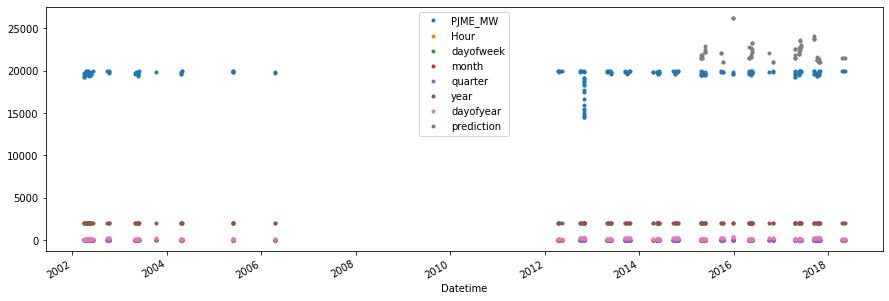

In [24]:
df.query('PJME_MW <20000').plot(figsize=(15, 5), style='.');

The above are values that seems to be outliers

In [25]:
#saving the dataframe having filtered out the outliers
df = df.query('PJME_MW > 19000').copy()


Time Series Cross Validation

In [26]:
from sklearn.model_selection import TimeSeriesSplit
t_split = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

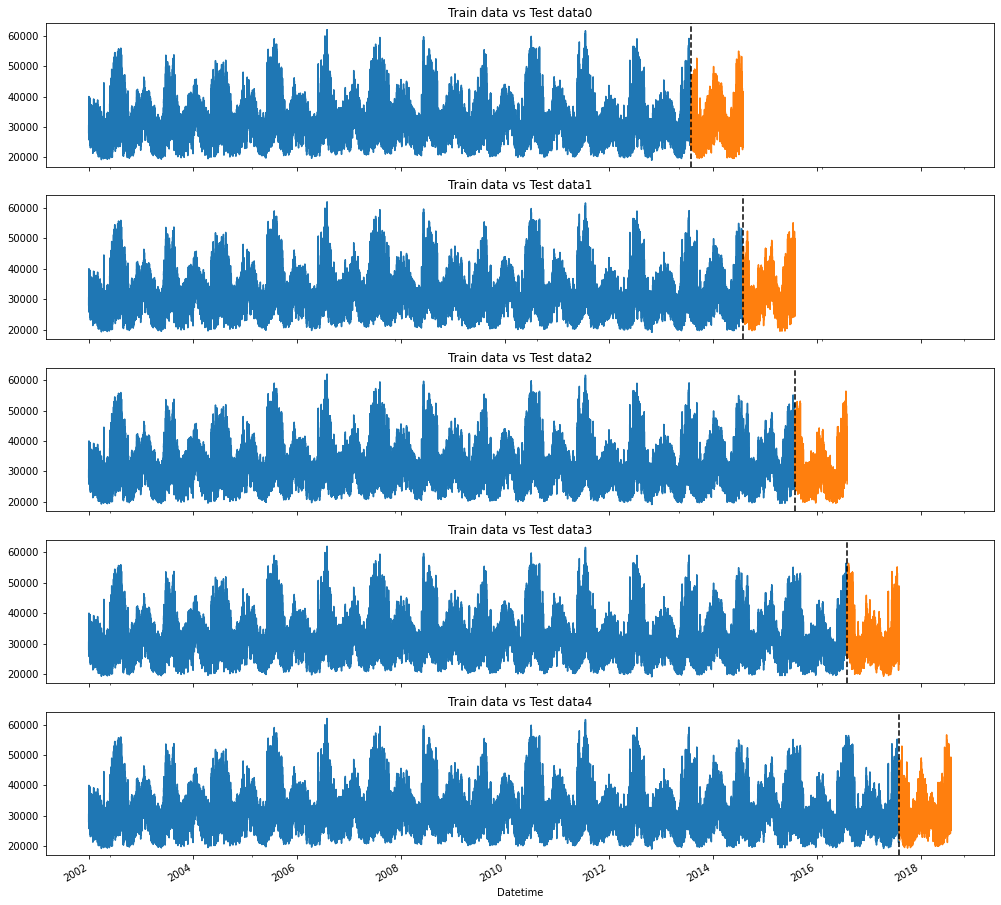

In [27]:
# visualize the the fold split
fig, axs = plt.subplots(5,1, figsize=(17,17),sharex=True)

fold = 0
for train_idx, val_idx in t_split.split(df):
  train = df.iloc[train_idx]
  test = df.iloc[val_idx]
  train['PJME_MW'].plot(ax=axs[fold],label='Traning Set', title = f'Train data vs Test data{fold}')
  test['PJME_MW'].plot(ax=axs[fold], label='Test set')
  axs[fold].axvline(test.index.min(), color='black', ls='--')
  fold +=1

plt.show()

Lag Feartures

In [28]:
def add_lags(df):
  target_map = df['PJME_MW'].to_dict()
  df['lag1'] = (df.index-pd.Timedelta('364 days')).map(target_map)
  df['lag2'] = (df.index-pd.Timedelta('728 days')).map(target_map)
  df['lag3'] = (df.index-pd.Timedelta('1092 days')).map(target_map)
  return df

df = add_lags(df)


In [29]:
df.head(2)

,PJME_MW,Hour,dayofweek,month,quarter,year,dayofyear,prediction,lag1,lag2,lag3
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN,NaN


In [30]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_feartures(train)
    test = create_feartures(test)

    FEATURES = ['dayofyear', 'Hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = Xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[13:22:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.3	validation_1-rmse:31956.2
[100]	validation_0-rmse:12532.1	validation_1-rmse:11907.3
[200]	validation_0-rmse:5741.75	validation_1-rmse:5353.56
[300]	validation_0-rmse:3867.59	validation_1-rmse:3890.84
[400]	validation_0-rmse:3430.06	validation_1-rmse:3753.97
[500]	validation_0-rmse:3313.45	validation_1-rmse:3768
[600]	validation_0-rmse:3257.11	validation_1-rmse:3781.86
[700]	validation_0-rmse:3217.39	validation_1-rmse:3791.6
[800]	validation_0-rmse:3182.34	validation_1-rmse:3799.21
[900]	validation_0-rmse:3152.74	validation_1-rmse:3789.43
[999]	validation_0-rmse:3120.68	validation_1-rmse:3782.09
[13:23:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32671.8	validation_1-rmse:32142.1
[100]	validation_0-rmse:12513.2	validation_1-rmse:12224.6


In [31]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3805.3721
Fold scores:[3782.0923499998917, 3432.6947225902877, 3715.2885293279937, 4065.531161097896, 4031.253750332521]


Predicting the Future

* Retraining on all data
* To Predict the future we need an emtpy dataframe for future date ranges.
* Run those dates through our feature creation code + lag creation

In [32]:
# Retrain on all data
df = create_feartures(df)

FEATURES = ['dayofyear', 'Hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = Xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[13:28:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.5
[100]	validation_0-rmse:12426.3
[200]	validation_0-rmse:5751.88
[300]	validation_0-rmse:3970.82
[400]	validation_0-rmse:3570.3
[499]	validation_0-rmse:3455.03


XGBRegressor(learning_rate=0.01, n_estimators=500)

In [33]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_feartures(df_and_future)
df_and_future = add_lags(df_and_future)

In [34]:
future_w_features = df_and_future.query('isFuture').copy()

Predicting

In [35]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

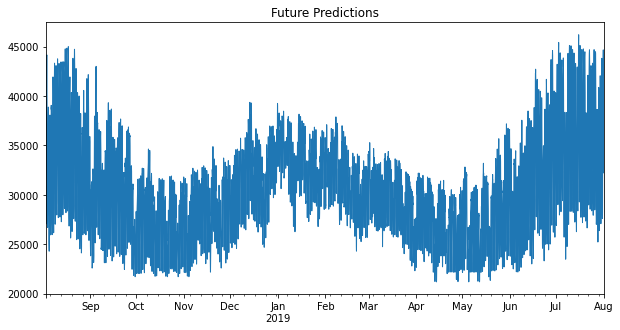

In [36]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=palette[0],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()


Saving the Model

In [37]:
# Save model
reg.save_model('model.json')

making predictions with our model

[13:28:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


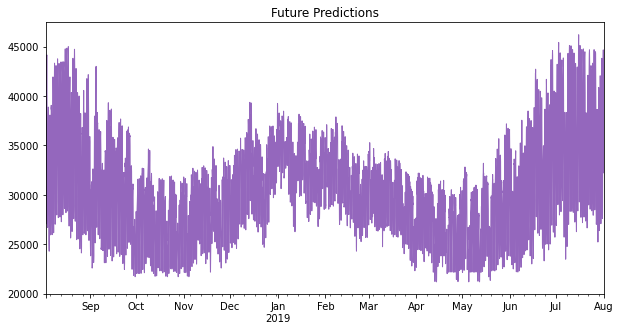

In [38]:
reg_new = Xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=palette[4],
                               ms=1, lw=1,
                               title='Future Predictions');